In [48]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="Root@123",
)

In [4]:
# Define a function to execute SQL queries and return results as a DataFrame
def execute_query(query):
    with conn.cursor() as cursor:
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        return pd.DataFrame(cursor.fetchall(), columns=columns)

In [5]:
query = """
SELECT * FROM public.xdr_data
"""

In [6]:
# Execute query and load data into DataFrame
df = execute_query(query)

In [7]:
# Check the first few rows of the DataFrame
print(df.head())

      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

In [8]:
def aggregate_user_behavior(df):
    """
    Aggregate user behavior metrics per user (MSISDN).

    Args:
    - df (DataFrame): Input DataFrame containing the raw data.

    Returns:
    - user_behavior_df (DataFrame): DataFrame with aggregated user behavior metrics.
    """
    # Group by MSISDN and aggregate metrics
    user_behavior_df = (
        df.groupby("MSISDN/Number")
        .agg(
            {
                "Bearer Id": "count",
                "Dur. (ms)": "sum",
                "Total DL (Bytes)": "sum",
                "Total UL (Bytes)": "sum",
                "Social Media DL (Bytes)": "sum",
                "Social Media UL (Bytes)": "sum",
                "Google DL (Bytes)": "sum",
                "Google UL (Bytes)": "sum",
                "Email DL (Bytes)": "sum",
                "Email UL (Bytes)": "sum",
                "Youtube DL (Bytes)": "sum",
                "Youtube UL (Bytes)": "sum",
                "Netflix DL (Bytes)": "sum",
                "Netflix UL (Bytes)": "sum",
                "Gaming DL (Bytes)": "sum",
                "Gaming UL (Bytes)": "sum",
                "Other DL (Bytes)": "sum",
                "Other UL (Bytes)": "sum",
            }
        )
        .reset_index()
    )

    return user_behavior_df

In [9]:
def handle_missing_values_and_outliers(df):
    """
    Handle missing values and outliers in the DataFrame by replacing them with column mean.

    Args:
    - df (DataFrame): Input DataFrame containing the raw data.

    Returns:
    - cleaned_df (DataFrame): DataFrame with missing values and outliers replaced with column mean.
    """
    # Replace missing values with column mean
    cleaned_df = df.fillna(df.mean())

    # Replace outliers with column mean
    for column in df.columns:
        if df[column].dtype != "object":
            cleaned_df[column] = np.where(
                (cleaned_df[column] < cleaned_df[column].quantile(0.05))
                | (cleaned_df[column] > cleaned_df[column].quantile(0.95)),
                cleaned_df[column].mean(),
                cleaned_df[column],
            )

    return cleaned_df

In [10]:
# Aggregate user behavior metrics
user_behavior_df = aggregate_user_behavior(df)

# Handle missing values and outliers
cleaned_df = handle_missing_values_and_outliers(user_behavior_df)

# Display the first few rows of the cleaned DataFrame
print(cleaned_df.head())

   MSISDN/Number  Bearer Id  Dur. (ms)  Total DL (Bytes)  Total UL (Bytes)  \
0   4.511474e+10        1.0   116720.0      8.426375e+08      3.605311e+07   
1   4.511474e+10        1.0   181230.0      1.207552e+08      3.610446e+07   
2   4.511474e+10        1.0   134969.0      5.566597e+08      3.930682e+07   
3   4.511474e+10        1.0    49878.0      4.019932e+08      5.730942e+07   
4   4.511474e+10        2.0    37104.0      1.363130e+09      9.428053e+07   

   Social Media DL (Bytes)  Social Media UL (Bytes)  Google DL (Bytes)  \
0                2206504.0                  25631.0          3337123.0   
1                2598548.0                  62017.0          4197697.0   
2                3148004.0                  47619.0          3343483.0   
3                 251469.0                  28825.0          5937765.0   
4                2861230.0                  51312.0         13728668.0   

   Google UL (Bytes)  Email DL (Bytes)  Email UL (Bytes)  Youtube DL (Bytes)  \
0     

In [11]:
# Display information about the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [12]:
# Display summary statistics for numeric columns
print(df.describe())

          Bearer Id       Start ms         End ms     Dur. (ms)          IMSI  \
count  1.490100e+05  150000.000000  150000.000000  1.500000e+05  1.494310e+05   
mean   1.013887e+19     499.188200     498.800880  1.046086e+05  2.082016e+14   
std    2.893173e+18     288.611834     288.097653  8.103762e+04  2.148809e+10   
min    6.917538e+18       0.000000       0.000000  7.142000e+03  2.040471e+14   
25%    7.349883e+18     250.000000     251.000000  5.744050e+04  2.082014e+14   
50%    7.349883e+18     499.000000     500.000000  8.639900e+04  2.082015e+14   
75%    1.304243e+19     749.000000     750.000000  1.324302e+05  2.082018e+14   
max    1.318654e+19     999.000000     999.000000  1.859336e+06  2.140743e+14   

       MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
count   1.489350e+05  1.494290e+05    122172.000000    122189.000000   
mean    4.188282e+10  4.847455e+13       109.795706        17.662883   
std     2.447443e+12  2.241637e+13       619.782739   

In [14]:
# Compute variance
variance = df["Dur. (ms)"].var()

# Compute standard deviation
std_deviation = df["Dur. (ms)"].std()

# Compute range
data_range = df["Dur. (ms)"].max() - df["Dur. (ms)"].min()

# Compute interquartile range (IQR)
Q1 = df["Dur. (ms)"].quantile(0.25)
Q3 = df["Dur. (ms)"].quantile(0.75)
IQR = Q3 - Q1

# Print results
print("Variance:", variance)
print("Standard Deviation:", std_deviation)
print("Range:", data_range)
print("Interquartile Range (IQR):", IQR)

Variance: 6567096094.97398
Standard Deviation: 81037.62147900184
Range: 1852194.0
Interquartile Range (IQR): 74989.75


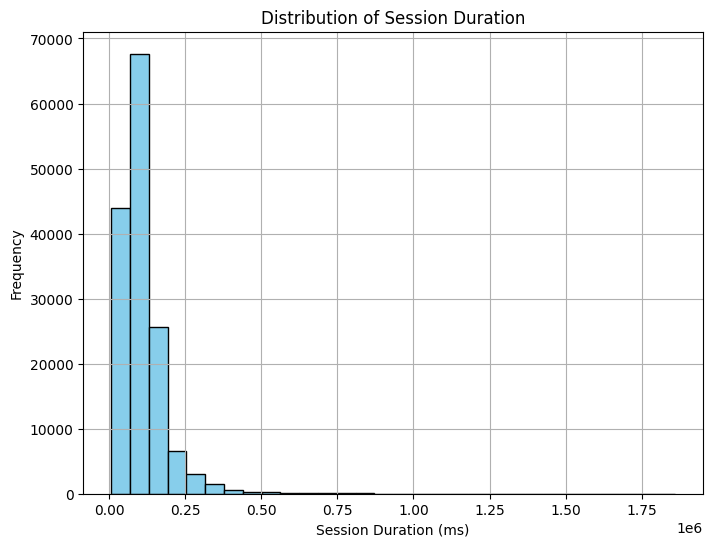

In [17]:
# Create a histogram for session duration
plt.figure(figsize=(8, 6))
plt.hist(df["Dur. (ms)"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Session Duration")
plt.xlabel("Session Duration (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

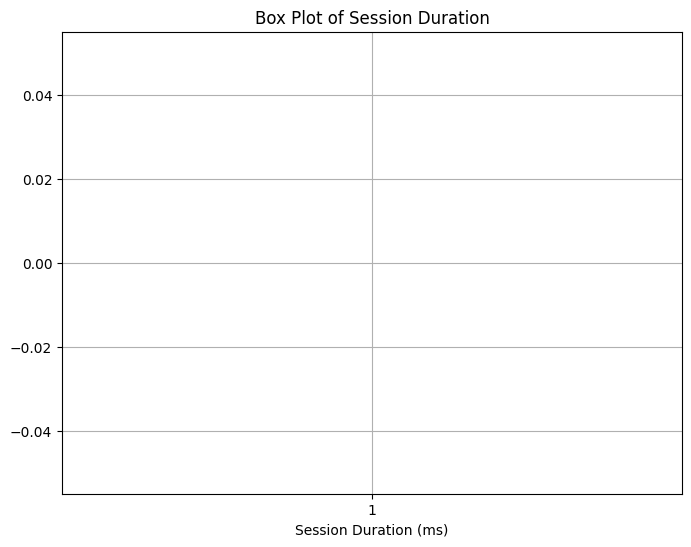

In [40]:
# Create a box plot for session duration
plt.figure(figsize=(8, 6))
plt.boxplot(df["Dur. (ms).1"], vert=False)
plt.title("Box Plot of Session Duration")
plt.xlabel("Session Duration (ms)")
plt.grid(True)
plt.show()

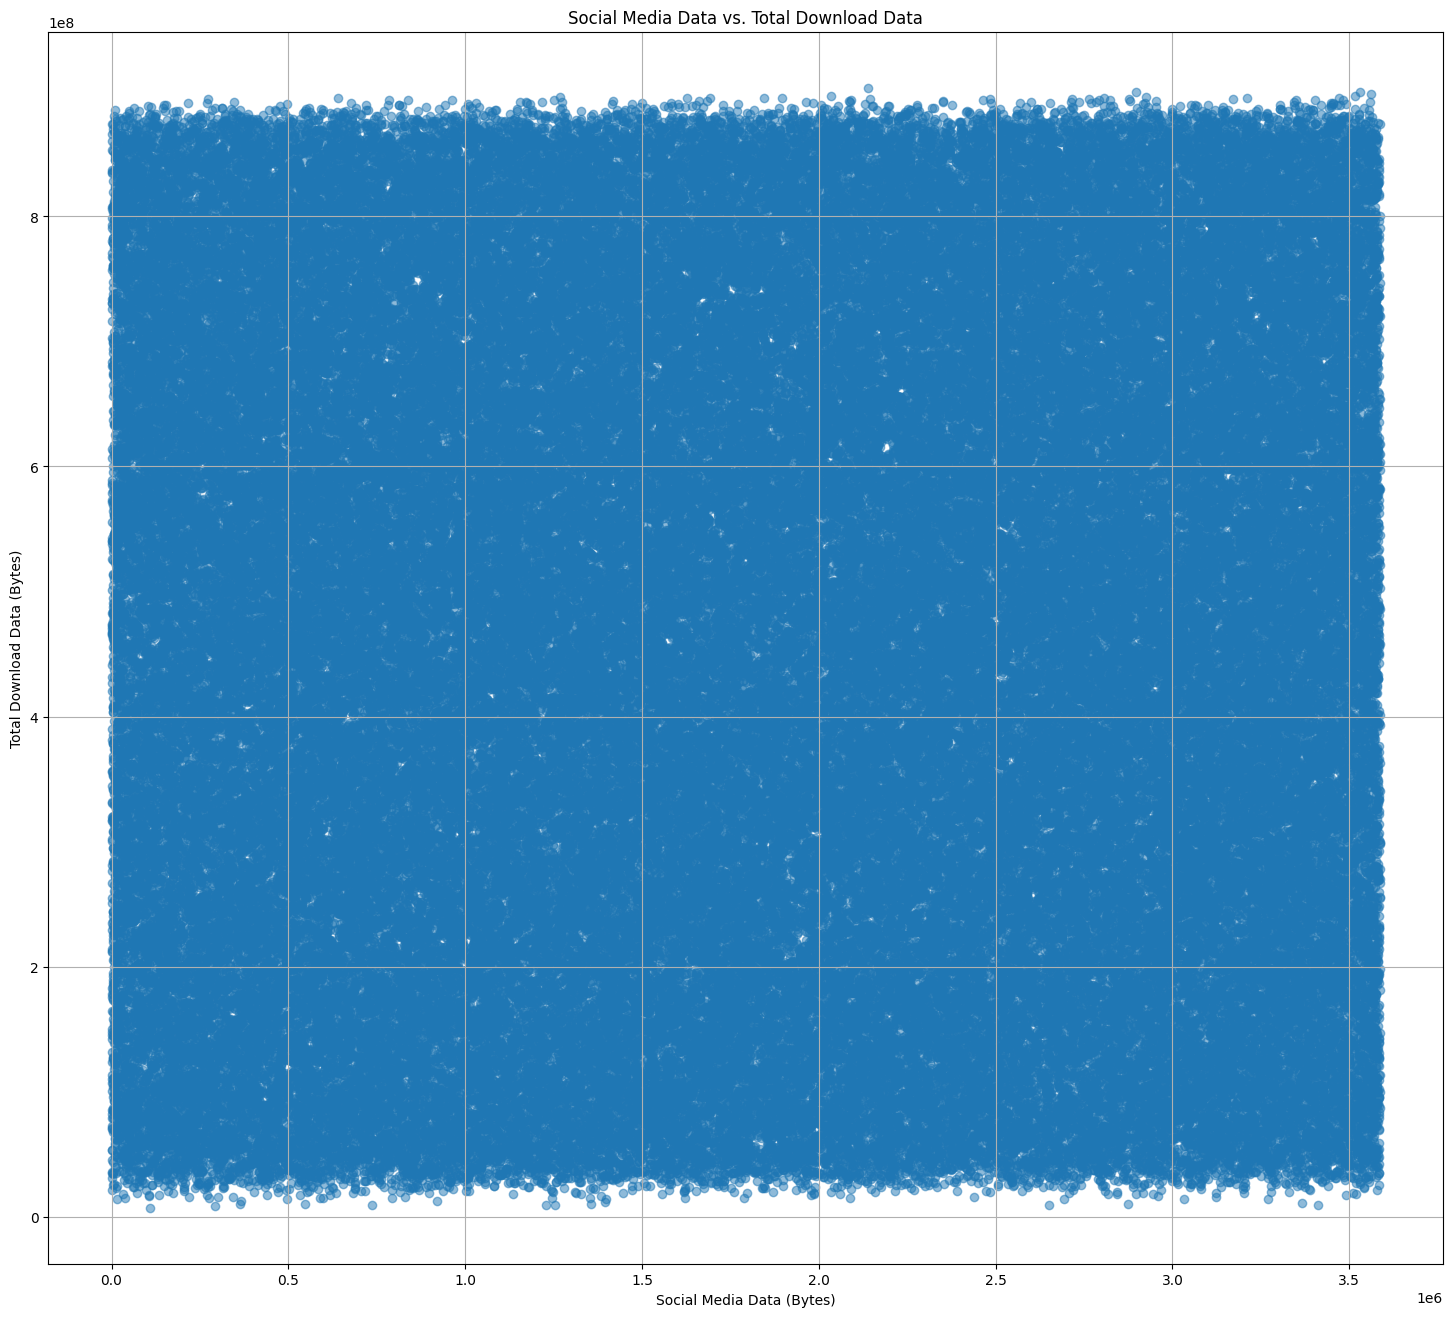

In [35]:
# Create a scatter plot for Social Media data vs. Total DL data
plt.figure(figsize=(18, 16))
plt.scatter(df["Social Media DL (Bytes)"], df["Total DL (Bytes)"], alpha=0.5)
plt.title("Social Media Data vs. Total Download Data")
plt.xlabel("Social Media Data (Bytes)")
plt.ylabel("Total Download Data (Bytes)")
plt.grid(True)
plt.show()

In [44]:
# Compute total duration per user
total_duration_per_user = df.groupby("MSISDN/Number")["Dur. (ms)"].sum()

# Segment users into decile classes based on total duration
decile_classes = pd.qcut(total_duration_per_user, q=10, labels=False)

# Add decile class information to the DataFrame
df["Decile Class"] = decile_classes

# Compute total data (DL+UL) per decile class
total_data_per_decile = df.groupby("Decile Class")[
    ["Total DL (Bytes)", "Total UL (Bytes)"]
].sum()

In [46]:
# Specify the correct column names for correlation analysis
selected_columns = [
    "Social Media DL (Bytes)",
    "Google DL (Bytes)",
    "Email DL (Bytes)",
    "Youtube DL (Bytes)",
    "Netflix DL (Bytes)",
    "Gaming DL (Bytes)",
    "Other DL (Bytes)",
]

# Compute correlation matrix
correlation_matrix = df[selected_columns].corr()

# Print correlation matrix
print(correlation_matrix)

                         Social Media DL (Bytes)  Google DL (Bytes)  \
Social Media DL (Bytes)                 1.000000          -0.001954   
Google DL (Bytes)                      -0.001954           1.000000   
Email DL (Bytes)                        0.004745          -0.000039   
Youtube DL (Bytes)                     -0.001389           0.001760   
Netflix DL (Bytes)                     -0.001817           0.000548   
Gaming DL (Bytes)                       0.001018          -0.001421   
Other DL (Bytes)                        0.006126          -0.002557   

                         Email DL (Bytes)  Youtube DL (Bytes)  \
Social Media DL (Bytes)          0.004745           -0.001389   
Google DL (Bytes)               -0.000039            0.001760   
Email DL (Bytes)                 1.000000            0.001679   
Youtube DL (Bytes)               0.001679            1.000000   
Netflix DL (Bytes)               0.001351            0.001202   
Gaming DL (Bytes)                0.000050

In [49]:
# Select columns for PCA
selected_columns = [
    "Social Media DL (Bytes)",
    "Google DL (Bytes)",
    "Email DL (Bytes)",
    "Youtube DL (Bytes)",
    "Netflix DL (Bytes)",
    "Gaming DL (Bytes)",
    "Other DL (Bytes)",
]

# Prepare data for PCA
X = df[selected_columns]

# Initialize PCA
pca = PCA(n_components=2)  # Specify the number of components

# Fit PCA
principal_components = pca.fit_transform(X)

# Create a DataFrame for the principal components
principal_df = pd.DataFrame(data=principal_components, columns=["PC1", "PC2"])

# Print explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.501595   0.49753482]
